# The way you define groups affects your statistical tests

This notebook is, I hope, a step towards explaining the issue and sharing some intuition about

* the difference between experiments where classes to be compared are under the control of the experimenter, and those where they are *predicted* or otherwise subject to error
* the importance to interpreting a statistical test of knowing the certainty with which individual data points are assigned to the classes being compared
* the effects of classification false positive and false negative rate, and an imbalance of membership between classes being compared

## Overview: Experiment

Let's say you have data from an experiment. The experiment is to test the binding of some human drug candidates to a large number (thousands) of mouse proteins. The experiment was conducted with transformed mouse proteins in yeast, so some of the proteins are in different states to how they would be found in the mouse: truncated to work in yeast, and with different post-translational modifications.

## Overview: Analysis

Now let's consider one possible analysis of the data. We will test whether the mouse proteins that bind to the drug are more similar to their human equivalents than those that do not bind to the drug.

We are ignoring the question of what 'equivalent' means here, and assume that a satisfactory equivalency is known and accepted. We will represent the 'strength' of equivalence by percentage sequence identity of each mouse protein to its human counterpart, on a scale of 0-100%.

We will test whether there is a difference between the two groups by a $t$-test of two samples. We assume that each group (binds/does not bind) subsamples a distinct, normally-distributed population of sequence identities. We do not know whether the means or variances of these populations are the same, but we will test the null hypothesis that the means are identical (or the difference between means is zero).

This isn't the way I would want to analyse this kind of data in a real situation - but we're doing it here to show the effect of how we define groups. We'll define *positive* and *negative* groups as follows:

* ***positive***: mouse protein that binds to drug in the yeast experiment
* ***negative***: mouse protein that does not bind to drug in the yeast experiment

## Python code:

Let's take a look at what we're actually doing when we perform this analysis. We'll use some Python code to visualise and explore this. Skip over this if you like…

In [1]:
%pylab inline
from scipy import stats
from ipywidgets import interact, fixed

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sample_distributions(mu_neg, mu_pos, sd_neg, sd_pos,
                         n_neg, n_pos, fnr, fpr,
                         clip_low, clip_high):
    """Returns subsamples and observations from two normal 
    distributions.
    
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples    
    """
    # subsamples
    samples = (clip(stats.norm.rvs(mu_neg, sd_neg, size=n_neg), clip_low, clip_high),
               clip(stats.norm.rvs(mu_pos, sd_pos, size=n_pos), clip_low, clip_high))
    # observed samples, including FPR and FNR
    [shuffle(s) for s in samples]
    obs_neg = concatenate((samples[0][:int((1-fpr)*n_neg)], 
                           samples[1][int((1-fnr)*n_pos):]))
    obs_pos = concatenate((samples[1][:int((1-fnr)*n_pos)],
                           samples[0][int((1-fpr)*n_neg):]))
    # return subsamples and observations
    return ((samples[0], samples[1]), (obs_neg, obs_pos))

def draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5,
                           n_neg=100, n_pos=100,
                           fnr=0, fpr=0,
                           clip_low=0, clip_high=100,
                           num_bins=50,
                           xmin=50, xmax=100, points=100,
                           subsample=True,
                           negcolor='blue', poscolor='green'):
    """Renders a matplotlib plot of normal distributions and subsamples,
    and returns t-test P values that the means of the two subsamples are
    equal, with and without FNR/FPR.
    
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples
    - bins       number of bins for histogram
    - xmin       x-axis lower limit
    - xmax       x-axis upper limit
    - points     number of points for plotting PDF
    - subsample  Boolean: True plots subsamples
    """
    x = linspace(points, xmin, xmax)
    # Normal PDFs
    norms = (normpdf(x, mu_neg, sd_neg), normpdf(x, mu_pos, sd_pos))
    # Get subsamples and observations
    samples, obs = sample_distributions(mu_neg, mu_pos, sd_neg, sd_pos,
                                        n_neg, n_pos, fnr, fpr,
                                        clip_low, clip_high)
    # Plot distribution and samples
    plot(x, norms[0], color=negcolor)
    plot(x, norms[1], color=poscolor)
    if subsample:
        h_neg = hist(samples[0], num_bins, normed=1, facecolor=negcolor, alpha=0.5)
        h_pos = hist(samples[1], num_bins, normed=1, facecolor=poscolor, alpha=0.5)
    ax = gca()
    ax.set_xlabel("value")
    ax.set_ylabel("frequency")
    # Calculate t-tests
    t_sam = stats.ttest_ind(samples[0], samples[1], equal_var=False)
    t_obs = stats.ttest_ind(obs[0], obs[1], equal_var=False)
    ax.set_title("$P_{real}$: %.02e $P_{obs}$: %.02e" % (t_sam[1], t_obs[1]))

## A perfect experiment:

First, we're assuming that there are two "real" populations of sequence identity between mouse and human equivalents - one representing proteins that bind to the drug in the experiment; one representing proteins that do not bind to the drug in this experiment. We're also assuming that the distribution of these values is Normal.

Giving ourselves a decent chance for success, we'll assume that the real situation for drug-binding proteins is that they have a mean sequence identity of around 90%, and those proteins that don't bind the drug have a mean identity of 85% to their human counterpart. We'll also assume that the standard deviation of thes identities is 5% in each case.

These are the "**real**", but idealised, populations from which our experimental results are drawn.

We can see how these distributions look:

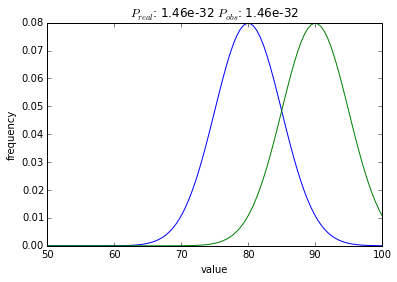

In [3]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, subsample=False)

A $t$-test between samples of these populations is not consistent with the null hypothesis: that both means are equal. The reported P-value in the plot title tells us that the probability of seeing this data (or a greater difference between the population means) is $P_{real}$ and is pretty small. No-one should have difficulty seeing that these populations have different means.

**NOTE:** The $t$-test is calculated on the basis of a 100-item subsample of each population and $P$-values will change when you rerun the cell.

When the experiment is performed, the results are not these idealised populations, but **observations** that are subsampled from the population.

We'll say that we find fewer mouse proteins that bind the drug than do not and, for the sake of round numbers, we'll have:

* 100 *positive* results: mouse protein binds drug
* 2000 *negative* results: mouse protein does not bind drug

And we can show this outcome:

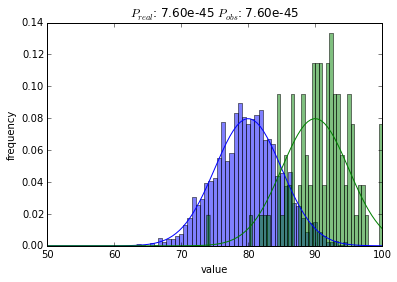

In [4]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100)

Now the frequency of each experimental group is also plotted, as a histogram. The blue group - our negative examples, match the idealised distribution well. The green group - our positives - match the profile less well, but even so the difference between means is visibly apparent.

The title of the plot shows two $P$-values from the $t$-test, which is again very small. The null hypothesis: that the means are equal, is rejected.

## Experimental error in classification

For many experiments, the experimenter is in complete control of sample classification, throughout. 

For example, the experimenter either does, or does not, inject a mouse with a drug. The 'experimental' sample is easily and *absolutely* distinguished from the control. In this case, $t$-tests are simple to apply, with relatively few caveats.

This easy distinction between 'experiment' and 'control' samples is such a common circumstance, that it is easy to fall into the trap of thinking that it is always a clear division. But it is not, and it is increasingly less so when the samples being compared derive from high-throughput experiments, as in our fictional example, here.

When the categories being compared are classified as the result of an experiment or prediction that has an inherent error in classification, then we may be comparing hybrid populations of results: mixtures of positive and negative examples - and this can potentially affect the analysis results.

### Where does classification error come from?

In our fictional experiment every interaction is taking place in yeast, so the biochemistry is different to the mouse and may affect the outcome of binding. Furthermore, the assay itself will have detection limits (some real - maybe productive - binding will not be detected).

Although we are doing the experiment in yeast, we want to claim that the results tell us something about interaction in the mouse. Why is that? It is in part because the comparison of mouse protein sequence identity to the human counterpart protein implies that we care about whether the interaction is similar in the human and mouse system. It is also because the implication of binding in the yeast experiment is efficacy in the animal system.

The experiment is an imperfect proxy for detecting whether the drug "really binds" to each protein in the mouse. Not every individual binding outcome will be correct. Errors arise in comparison to what happens in the mouse, and also simple experimental error or variation. We can therefore define outcomes for each individual test:

* ***true positive***: the drug binds in the yeast experiment, and in the mouse
* ***true negative***: the drug does not bind in the yeast experiment, and does not bind in the mouse
* ***false positive***: the drug binds in the yeast experiment, but does not in the mouse
* ***false negative***: the drug does not bind in the yeast experiment, but does bind in the mouse

### Introducing false negatives

We can look at the effect of introducing a *false negative rate* (FNR: the probability that a protein which binds the drug in the mouse gives a negative result in yeast).

We'll start it low, at $FNR=0.01$:

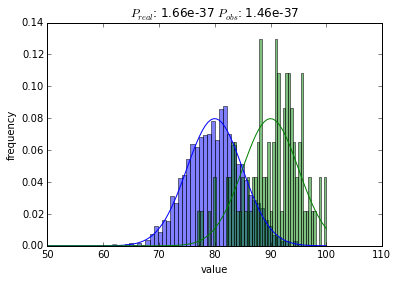

In [5]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fnr=0.01)

Again, the $P$-value reported by the $t$-test allows us to reject the null hypothesis. But there's a difference to the earlier graphs, as the two $P$-values in the title differ. That is because they represent two different tests.

* $P_{real}$: the $P$-value obtained with no false positives or false negatives. This is the $P$-value we would get if we could correctly assign every protein to be either 'binding' or 'non-binding' of the drug, in the yeast experiment.
* $P_{obs}$: the $P$-value obtained from our observed dataset, which could contain either false positives or false negatives. This is the $P$-value we would get if the yeast experiment had the same false positive or false negative rate.

In this case, with *FNR*=0.01, and 100 'true' positive interactors, we should expect approximately one 'true' positive to be misclassified as a 'negative', and the resulting effect on our test to be quite small. This is, in fact, what we see - $P_{obs}$ should be very slightly higher than $P_{real}$.

### Increasing the rate of false negatives

If we increase the rate of false negatives to first $FNR=0.1$ and then $FNR=0.2$, we see a greater influence on our statistical test:

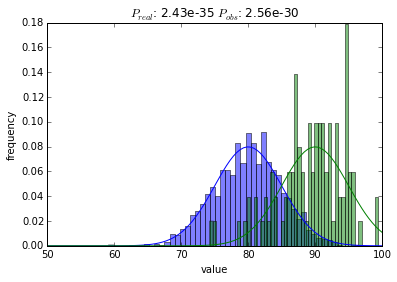

In [6]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fnr=0.1)

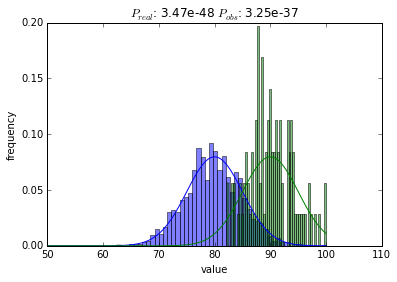

In [7]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fnr=0.2)

Now the $t$-test reports several orders of magnitude difference in $P$-values. Both are still very small, and the difference in population means is clear, but the trend is obvious: misclassification moves the reported $P$-value closer to accepting the null hypothesis that both populations have the same mean.

### Introducing false positives

Now let's introduce a *false positive rate* (FPR: the probability that a protein which does not bind the drug in the mouse does so in the yeast experiment).

Again, starting low, at $FNR=0.01$:

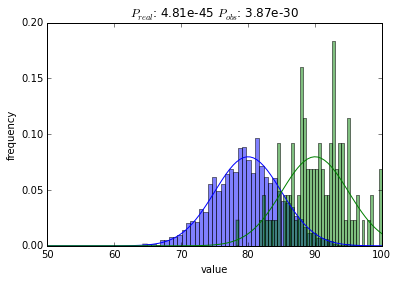

In [8]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.01)

The direction of change is again the same: with false positive errors, the test $P$-value moves towards accepting the null hypothesis. Also, the size of this change is (probably - it might change if you rerun the notebook) greater than that which we saw for $FNR=0.01$. 

The increase in effect is because the sample sizes for positive and negative groups differ. 1% of a sample of 2000 negatives is 20; 1% of a sample of 100 is 1. Misclassifying 20 negatives in the middle of 100 positives is likely to have more effect than misclassifying a single positive amongst 2000 negatives.

This tendency becomes more pronounced as we increase $FPR$:

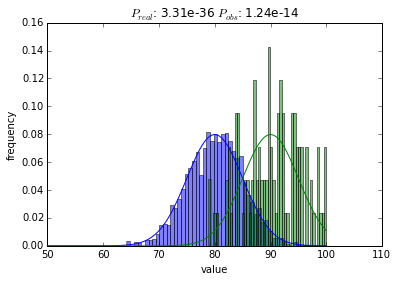

In [9]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.1)

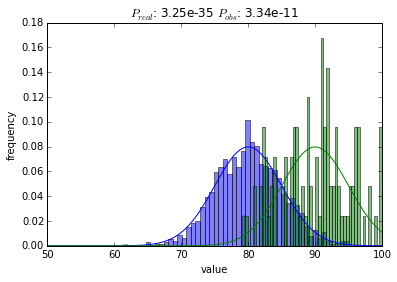

In [10]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.2)

With $FPR=0.2$, the $t$-test now reports a $P$-value that can be 20-30 orders of magnitude different from what would be seen with no misclassification. This is a considerable move towards being less able to reject the null hypothesis in what we might imagine to be a clear-cut case of having two distinct populations.

### Combining false negatives and false positives

As might be expected, the effect of combining false positive and false negative misclassifications is greater than either case alone. This is illustrated in the plots below.

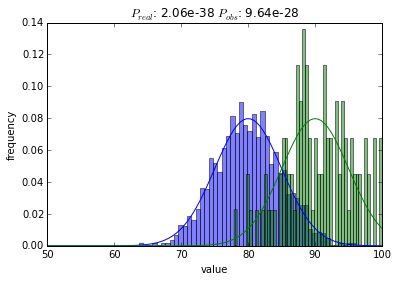

In [11]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.01, fnr=0.01)

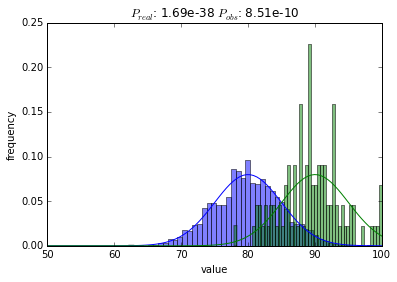

In [12]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.1, fnr=0.1)

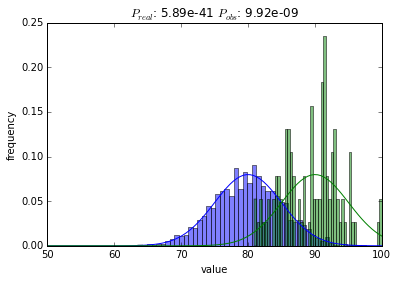

In [13]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.2, fnr=0.2)

## The effects of class size

We have seen that the relative sizes of positive and negative classes affect whether $FPR$ or $FNR$ is the more influential error type for this data. The total size of classes also has an influence. In general, reducing the number of class members increases the impact of misclassification, in part because the smaller sample size overall makes it harder to reject the null hypothesis as a 'baseline':

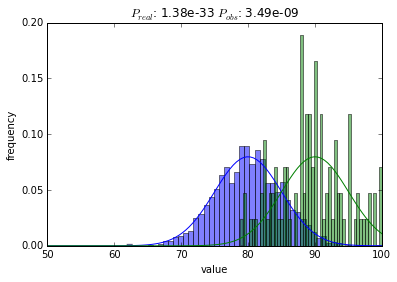

In [14]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.1, fnr=0.1)

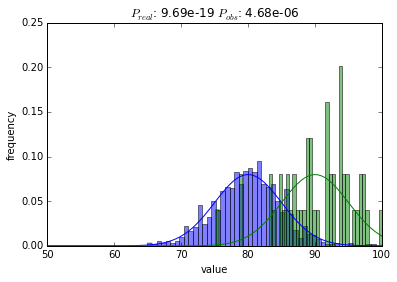

In [15]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=1000, n_pos=50, fpr=0.1, fnr=0.1)

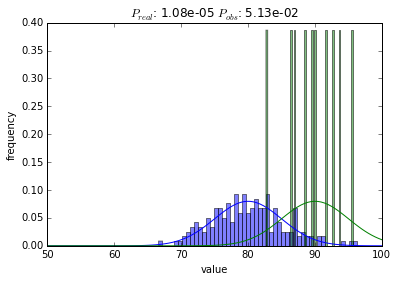

In [16]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=200, n_pos=10, fpr=0.1, fnr=0.1)

Some realisations of the last example (`n_neg=200, n_pos=10, fpr=0.1, fnr=0.1`) result in a $P$-value that (at the 0.05 level) rejects the null hypothesis when there is no misclassification, but cannot reject the null hypothesis when misclassification is taken into account.

**Misclassification of samples into categories can prevent statistical determination of category differences, even for distinct categories**

## The general case

All our examples so far have been single realisations of a fictional experiment. The results will vary every time you (re-)run a cell, and quite greatly between runs, especially for some parameter values.

Let's look at what happens over several hundred replications of the experiment, to pick up on some trends.

### Python code

As before, ignore this if you don't want to look at it.

In [17]:
def multiple_samples(n_samp=1000,
                     mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5,
                     n_neg=100, n_pos=100,
                     fnr=0, fpr=0,
                     clip_low=0, clip_high=100):
    """Returns the distribution of P-values obtained from subsampled
    and observed (with FNR/FPR) normal distributions, over n_samp
    repetitions.
    
    - n_samp     number of times to (re)sample from the distribution
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples 
    """
    p_sam, p_obs = [], []
    for n in range(n_samp):
        samples, obs = sample_distributions(mu_neg, mu_pos, sd_neg, sd_pos,
                                            n_neg, n_pos, fnr, fpr,
                                            clip_low, clip_high)
        t_sam = stats.ttest_ind(samples[0], samples[1], equal_var=False)
        t_obs = stats.ttest_ind(obs[0], obs[1], equal_var=False)        
        p_sam.append(t_sam[1])
        p_obs.append(t_obs[1])
    # return the P-values
    return (p_sam, p_obs)

def draw_multiple_samples(n_samp=1000,
                          mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5,
                          n_neg=100, n_pos=100,
                          fnr=0, fpr=0,
                          clip_low=0, clip_high=100,
                          logy=True):
    """Plots the distribution of P-values obtained from subsampled
    and observed (with FNR/FPR) normal distributions, over n_samp
    repetitions.
    
    - n_samp     number of times to (re)sample from the distribution
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples    
    """
    p_sam, p_obs = multiple_samples(n_samp, mu_neg, mu_pos,
                                    sd_neg, sd_pos, n_neg, n_pos,
                                    fnr, fpr, clip_low, clip_high)
    # plot P-values against each other
    if logy:
        p = loglog(p_sam, p_obs, 'o', alpha=0.3)
    else:
        p = semilogx(p_sam, p_obs, 'o', alpha=0.3)
    ax = gca()
    ax.set_xlabel("'Real' subsample P-value")
    ax.set_ylabel("Observed subsample P-value")
    ax.set_title("reps=%d $n_{neg}$=%d $n_{pos}$=%d FNR=%.02f FPR=%.02f" %
                 (n_samp, n_neg, n_pos, fnr, fpr))
    # Add y=x lines, P=0.05
    lims = [min([ax.get_xlim(), ax.get_ylim()]),
            max([(0.05, 0.05), max([ax.get_xlim(), ax.get_ylim()])])]
    if logy:
        loglog(lims, lims, 'k', alpha=0.75)
    else:
        semilogx(lims, lims, 'k', alpha=0.75)
    ax.set_aspect('equal')
    vlines(0.05, min(ax.get_ylim()), max(max(ax.get_ylim()), 0.05), color='red') # add P=0.05 lines
    hlines(0.05, min(ax.get_xlim()), max(max(ax.get_xlim()), 0.05), color='red')

### The perfect experiment

Assuming $FNR=0$ and $FPR=0$, i.e. no misclassification at all, the *observed* and *real* subsample $t$-test values are always identical. We plot $t$-test $P$-values results for 1000 replicates of our fictional experiment, below:

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


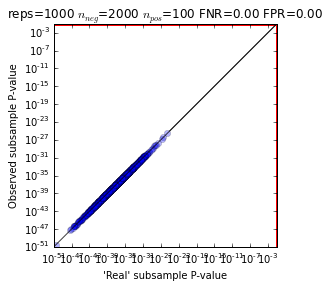

In [18]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100)

The red lines in the plot indicate a nominal $P=0.05$ threshold. 

The vertical line indicates this for the 'real' data - that is to say that points on the left of this line indicate a 'real' difference between the means of the populations (we reject the null hypothesis) at $P=0.05$.

The horizontal line indicates a similar threshold at $P=0.05$ for the 'observed' data - that which has some level of misclassification. Points below this line indicate that the experiment - with misclassification - rejects the null hypothesis at $P=0.05$.

Here, there is no misclassification, and all points lie on the diagonal, accordingly. The two populations we draw from are quite distinct, so all points cluster well to the left of and below the $P=0.05$ thresholds. 

### The effect of $FNR$

We saw before that, due to the small relative size of the positive set, the effect of $FNR$ was not very pronounced. Running 1000 replicates of the experiment, we can get some intuition about how increasing $FNR$ affects the observed $P$-value, relative to that which we would see without any misclassification.

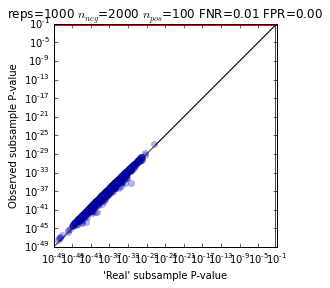

In [19]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fnr=0.01)

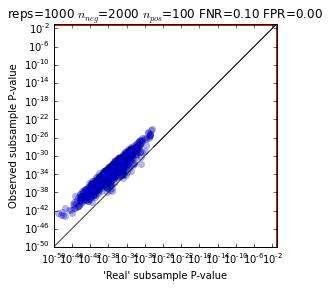

In [20]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fnr=0.1)

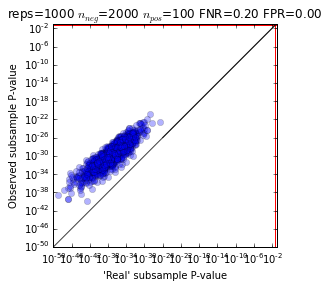

In [21]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fnr=0.2)

The effet of increasing $FNR$ is to move the reported $P$-values away from the $y=x$ diagonal, and towards the $P=0.05$ threshold. Even with $FNR=0.1$, almost every run of the experiment misreports the 'real' $P$-value such that we are less likely to reject the null hypothesis.

### The effect of $FPR$

We also saw earlier that, again due to the small relative size of the positive set, the effect of $FPR$ was greater than that of $FNR$. 

By running 1000 replicates of the experiment as before, we can understand how increasing $FPR$ affects the observed $P$-value, relative there being no misclassification.

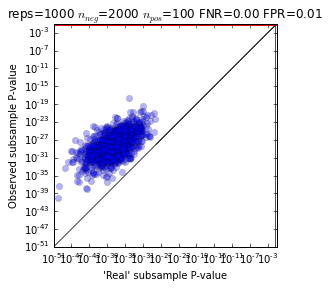

In [22]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.01)

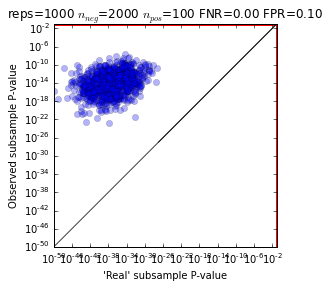

In [23]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.1)

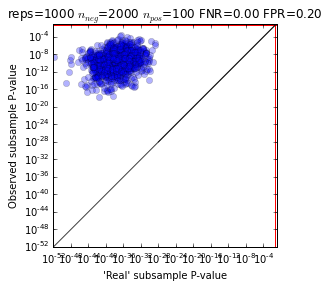

In [24]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.2)

We see the same progression of 'observed' $P$-values away from what would be the 'real' $P$-value without misclassification, but this time much more rapidly than with $FNR$ as $FPR$ increases. Even for this very distinct pair of populations, whose 'true' $P$-value should be ≈$10^-40$, an $FPR$ of 0.2 runs the risk of occasionally failing to reject the null hypothesis that the population means are the same.

As before, combining misclassification of positive and negative examples results in us being more likely to accept the null hypothesis, even for a very distinct pair of populations.

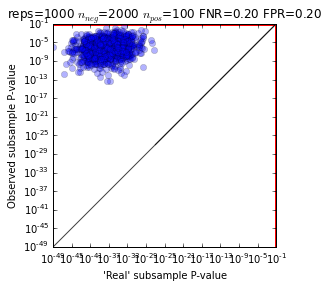

In [25]:
draw_multiple_samples(n_samp=1000, mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5, n_neg=2000, n_pos=100, fpr=0.2, fnr=0.2)

## A more realistic population?

The examples above have all been performed with two populations that have very distinct means, by $t$-test. How powerful is the effect of misclassification when the distinction is not so clear.

Let's consider two populations with less readily-distinguishable means, as might be encountered in real data:

$\mu_{neg}=85$, $\mu_{pos}=90$, $\sigma_{neg}=6$, $\sigma_{pos}=6$

Over 1000 repeated (perfect) experiments, pretty much all experiments reject the null hypothesis that the means are the same, at $P=0.05$, but some (rare) experiments might falsely accept this:

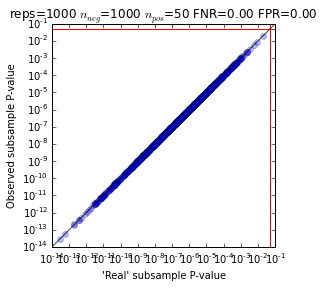

In [26]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50)

In a single realisation of a perfect experiment with no misclassification, the reported $P$-value is likely to very strongly reject the null-hypothesis:

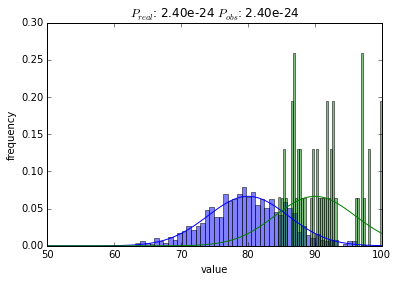

In [27]:
draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50)

In [28]:
### What is the impact of misclassification?

Now, we increase the level of misclassification modestly:

SyntaxError: invalid syntax (<ipython-input-28-607c8674eac8>, line 3)

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50, fnr=0.01, fpr=0.01)

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50, fnr=0.05, fpr=0.05)

And now, at $FPR=FNR=0.05$ we start to see the population of experiments creeping into the upper left quadrant. In this quadrant we have experiments where data that (if classified correctly) would reject the null hypothesis are observed to accept it instead. This problem gets worse as the rate of misclassification increases.

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50, fnr=0.1, fpr=0.1)

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50,
                      fnr=0.1, fpr=0.1, logy=False)

At $FPR=FNR=0.2$ 

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50, fnr=0.2, fpr=0.2)

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=90, sd_neg=6, sd_pos=6, n_neg=1000, n_pos=50,
                      fnr=0.2, fpr=0.2, logy=False)

## What does this all mean?

If we know that our experiment may involve misclassification into the groups we are going to compare, then we need to consider alternative statistical methods to $t$-tests, as misclassification can introduce quantitative (effect size) and qualitative (presence/absence of an effect) errors to our analysis.

The likelihood of such errors being introduced depends on the nature of the experiment: number of samples in each group, expected false positive and false negative rate, and the expected difference between the two groups. We need to have at least an estimate of each of these quantities to be able to determine whether a simple test (e.g. $t$-test) might be appropriate, whether we need to take misclassification into account explicitly, or whether the data are likely unable to give a decisive answer to our biological question.

A further point to consider is whether the initial assumption of the question/experiment is realistic. For instance, in our fictional example here, is it truly realistic to expect that our drug will only bind those mouse proteins that are most similar to their human counterparts? I would argue that this is unlikely, and that there are almost certainly proportionally as many proteins highly-similar to their human counterparts that do not bind the drug. As misclassification can tend to sway the result towards an overall false negative of "no difference between the groups" where there is one, it may be difficult to distinguish between faulty assumptions, and the effects of misclassification.

## Does misclassification always give an overall false negative?

No.

Sometimes, data that should not reject the null hypothesis can be reported as rejecting it: an overall false positive. These are the points in the lower-right quadrant, below:

In [ ]:
draw_multiple_samples(n_samp=1000, mu_neg=85, mu_pos=89, sd_neg=7, sd_pos=7, n_neg=150, n_pos=20,
                      fnr=0.1, fpr=0.15, logy=False)

Note that, apart from the overall sample size (170 mouse proteins instead of 2000) the parameters for this run are not very different from those we have been using.

## Interactive examples

The cells below allow you to explore variation in all the parameters we have modified above, and their effects on reported $P$ values:

In [ ]:
interact(draw_sample_comparison,
         mu_neg=(60, 99, 1), mu_pos=(60, 99, 1),
         sd_neg=(0, 15, 1), sd_pos=(0, 15, 1),
         n_neg=(0, 150, 1), n_pos=(0, 150, 1),
         fnr=(0, 1, 0.01), fpr=(0, 1, 0.01),
         clip_low=fixed(0), clip_high=fixed(100),
         num_bins=fixed(50), xmin=fixed(50),
         xmax=fixed(100), points=fixed(100),
         subsample=True, negcolor=fixed('blue'),
         poscolor=fixed('green'))

In [ ]:
interact(draw_multiple_samples,
         mu_neg=(60, 99, 1), mu_pos=(60, 99, 1),
         sd_neg=(0, 15, 1), sd_pos=(0, 15, 1),
         n_neg=(0, 150, 1), n_pos=(0, 150, 1),
         fnr=(0, 1, 0.01), fpr=(0, 1, 0.01),
         clip_low=fixed(0), clip_high=fixed(100))